# FH-CNN-Ensembling

In [7]:
import os, sys, re, json
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

from matplotlib import pyplot as plt
import seaborn as sns


sys.path.insert(0,'modules')
from fh_cnn_regressor import *


MODEL_PATH = './models'
DATA_PATH = '/Users/Cedric.Jouan@ibm.com/Documents/GDS/DEV/data'

W_STATIONS = ['KLKU']

## Load Models

In [8]:
model_names = [x for x in os.listdir(MODEL_PATH) if x[:2]=='FH']

models = {}
for model_name in model_names:
    model = {}
    model['horizon'] = int(model_name.split('_')[-1])
    
    #load deepl_model
    deepl_model = tf.keras.models.load_model(f'{MODEL_PATH}/{model_name}/deepl_model', custom_objects={"weighted_mae": weighted_mae})
    model['deepl_model'] = deepl_model
    
    #load /FeatureEngineering.pkl
    with open(f'{MODEL_PATH}/{model_name}/FeatureEngineering.pkl', 'rb') as f:
        f_eng = pickle.load(f)
    model['f_eng'] = f_eng
    
    #load TsEngineering.pkl
    with open(f'{MODEL_PATH}/{model_name}/TsEngineering.pkl', 'rb') as f:
        ts_eng = pickle.load(f)
    model['ts_eng'] = ts_eng

    
    #load CustomScaler.pkl
    with open(f'{MODEL_PATH}/{model_name}/CustomScaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    model['scaler'] = scaler
    
    models[model_name] = model


## Load Data

In [46]:
hf_df = pd.concat([pd.read_csv(DATA_PATH+f'/HF/{w_station}.csv') for w_station in W_STATIONS])
sd_df = pd.read_csv(DATA_PATH+f'/SD/sd_martin.csv')
ad_df = pd.read_csv(DATA_PATH+f'/AD/ad_martin.csv')
df = sd_df.merge(ad_df).merge(hf_df)

mask_complete = df.groupby('Forecast_date').apply(lambda x : x.shape[0]==(360+23)*len(W_STATIONS))
df = df[df['Forecast_date'].isin(mask_complete.index[mask_complete])].copy()

In [47]:
# df_input_payload = df.drop('kWh', axis=1)
# payload = {"input_data":[{"fields":df_input_payload.columns.tolist(), "values":df_input_payload.values.tolist()}]}
# import json
# with open('sample_payload.json', 'w') as f:
#     json.dump(payload, f)

In [48]:
# df_input_payload = df.drop('kWh', axis=1)
# df_input_payload = df.copy()

# i = 5

# df_input_payload = df_input_payload[df_input_payload['Forecast_date']==df_input_payload['Forecast_date'].iloc[i]].copy()
# payload = {"input_data":[{"fields":df_input_payload.columns.tolist(), "values":df_input_payload.values.tolist()}]}
# import json
# with open(f'sample_single_payload_{i}.json', 'w') as f:
#     json.dump(payload, f)

In [50]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

In [51]:
df['Forecast_date'] = pd.to_datetime(df['Forecast_date'])

# split_date = pd.to_datetime('2021-09-01 00:00:00')

# test = df[df['Forecast_date']>split_date].copy()

In [44]:
test.to_csv('test_data.csv')

In [45]:
test = pd.read_csv('test_data.csv')
test['Forecast_date'] = pd.to_datetime(test['Forecast_date'])
test['DateTime'] = pd.to_datetime(test['DateTime'])
test.set_index('DateTime', inplace=True)
test

,kWh,zenith,azimuth,isDay,Fcst Hour,Day or Night,Temp,DewPt,Heat Index,Wind Chill,...,Wind Direction,Gust,Cloud Cover,Visibility,Mean Sea Level Pressure,UV Index,Golf Index,Severity,Forecast_date,station_code
DateTime,,,,,,,,,,,,,,,,,,,,,


## Data Preparation

In [53]:
X_test = {model_name : model['scaler'].transform(model['f_eng'].transform(test)) for model_name, model in models.items()}
y_test = {model_name : model['ts_eng'].transform(test) for model_name, model in models.items()}

## Format Data

In [54]:
X_test = {model_name : format_input(X_test[model_name], test['Forecast_date'], test['station_code'], horizon=model['horizon']) \
          for model_name, model in models.items()}
y_test = {model_name : format_input(y_test[model_name], test['Forecast_date'], test['station_code'], horizon=model['horizon']) \
          for model_name, model in models.items()}

## Predict

In [55]:
y_pred = [model['deepl_model'].predict(X_test[model_name]) for model_name, model in models.items()]

## Pad

In [56]:
y_pred = np.array([np.concatenate([y, np.zeros((y.shape[0], int(360-y.shape[1])))], axis=1) for y in y_pred])

## Format

In [57]:
X = np.moveaxis(y_pred, 0, 2)
# y = models['FH_CNN_360']['ts_eng'].inverse_transform(y_test['FH_CNN_360'])
y = y_test['FH_CNN_360']

## Ensemble model

In [27]:
def create_ensemble_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10, input_shape=X.shape[1:], activation='relu'))
    model.add(tf.keras.layers.Dense(5, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    return model

In [28]:
# create_ensemble_model().summary()

In [29]:
model = create_ensemble_model()

model.compile(optimizer="Adam", loss="mae")
hist = model.fit(X, y, validation_split=0.2, batch_size=64, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 413ms/step - loss: 0.2075 - val_loss: 0.2123
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2074 - val_loss: 0.2122
Epoch 3/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2073 - val_loss: 0.2121
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2072 - val_loss: 0.2119
Epoch 5/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2070 - val_loss: 0.2119
Epoch 6/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2069 - val_loss: 0.2118
Epoch 7/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2068 - val_loss: 0.2116
Epoch 8/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2066 - val_loss: 0.2115
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2065 - val_loss: 0.2114
Epoch 10/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2063 - val_loss: 0.2112
Epoch 11/500
1/1 [

Epoch 84/500
1/1 [==============================] - 0s 13ms/step - loss: 0.1010 - val_loss: 0.1205
Epoch 85/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0998 - val_loss: 0.1195
Epoch 86/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0987 - val_loss: 0.1185
Epoch 87/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0976 - val_loss: 0.1175
Epoch 88/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0965 - val_loss: 0.1164
Epoch 89/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0954 - val_loss: 0.1153
Epoch 90/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1142
Epoch 91/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0932 - val_loss: 0.1132
Epoch 92/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0922 - val_loss: 0.1122
Epoch 93/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0912 - val_loss: 0.1112
Epoch 94/5

1/1 [==============================] - 0s 14ms/step - loss: 0.0664 - val_loss: 0.0840
Epoch 167/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0663 - val_loss: 0.0838
Epoch 168/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0663 - val_loss: 0.0836
Epoch 169/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0662 - val_loss: 0.0835
Epoch 170/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0661 - val_loss: 0.0833
Epoch 171/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0660 - val_loss: 0.0833
Epoch 172/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0659 - val_loss: 0.0832
Epoch 173/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0659 - val_loss: 0.0830
Epoch 174/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0658 - val_loss: 0.0829
Epoch 175/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0657 - val_loss: 0.0828
Epoch 176/500


1/1 [==============================] - 0s 14ms/step - loss: 0.0633 - val_loss: 0.0797
Epoch 249/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0633 - val_loss: 0.0797
Epoch 250/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 251/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 252/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 253/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 254/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 255/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0797
Epoch 256/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0797
Epoch 257/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0797
Epoch 258/500


1/1 [==============================] - 0s 15ms/step - loss: 0.0624 - val_loss: 0.0794
Epoch 331/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0794
Epoch 332/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0794
Epoch 333/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0794
Epoch 334/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0794
Epoch 335/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 336/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 337/500
1/1 [==============================] - 0s 16ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 338/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 339/500
1/1 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 340/500


1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 413/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 414/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 415/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 416/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 417/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 418/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 419/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 420/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0794
Epoch 421/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0794
Epoch 422/500


1/1 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 495/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 496/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 497/500
1/1 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 498/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 499/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 500/500
1/1 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0793


In [30]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

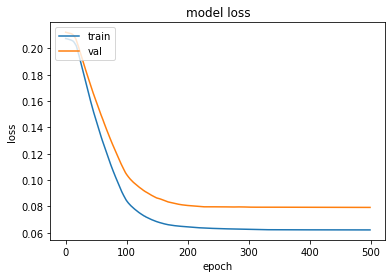

In [31]:
plot_history(hist)

In [ ]:
# model.save(MODEL_PATH+'/ensembler_model')

## Evaluate

!!! We don't have a proper test set for this wrapper model, the evaluation is not accurate !!! 

In [58]:
y_pred = model.predict(X)
y_pred = y_pred[:,:,0]

In [59]:
y_pred = ts_eng.inverse_transform(y_pred)
y_test = ts_eng.inverse_transform(y)

In [ ]:
y_test_cum = np.cumsum(y_test, axis=1)
y_pred_cum = np.cumsum(y_pred, axis=1)

error = abs(y_pred_cum - y_test_cum)/y_test_cum

In [ ]:
print(f'Model Global MAE : {np.mean(error)}')

# Visualizations

In [ ]:
def error_to_df(error, horizon_slice=(0,360)):
    frames = []
    for i, e in enumerate(error):
        tmp = pd.DataFrame({'horizon':[k+1 for k in range(len(e))],'error':e})
        frames.append(tmp)
    df_error = pd.concat(frames)
    df_error.reset_index(drop=True, inplace=True)
    
    return df_error[(df_error['horizon']>horizon_slice[0])&(df_error['horizon']<horizon_slice[1])]

In [ ]:
error_df = error_to_df(error, horizon_slice=(5, 360))

In [ ]:
sns.lineplot(data = error_df, x='horizon', y='error')  

## Deep Dive Visualization

In [ ]:
def plot_indiv_test_sample(i, pred, test):
    plt.plot(pred[i])
    plt.plot(test[i])
    plt.title('model output')
    plt.ylabel('output')
    plt.xlabel('epoch')
    plt.legend(['prediction', 'actual'], loc='upper left')
    plt.show()

In [ ]:
plot_indiv_test_sample(1,  y_pred_cum, y_test_cum)

In [ ]:
plot_indiv_test_sample(1,  y_pred, y_test)